In [3]:
library(dplyr)
library("ggpubr")
samples<-read.csv("./named/pgbench_all/instance_store_backed/pgbench_16*c3.large_instancestore_reverse_labeled.csv")

## indicators of whole experiment

In [4]:
wholeExp = samples[,'transactions']
indicators=data.frame()
indicators<-rbind(indicators,c(range(wholeExp),mean(wholeExp),median(wholeExp)))
names(indicators)<-c('min','max','mean','median')
indicators

min,max,mean,median
66946,85192,76723.88,76133


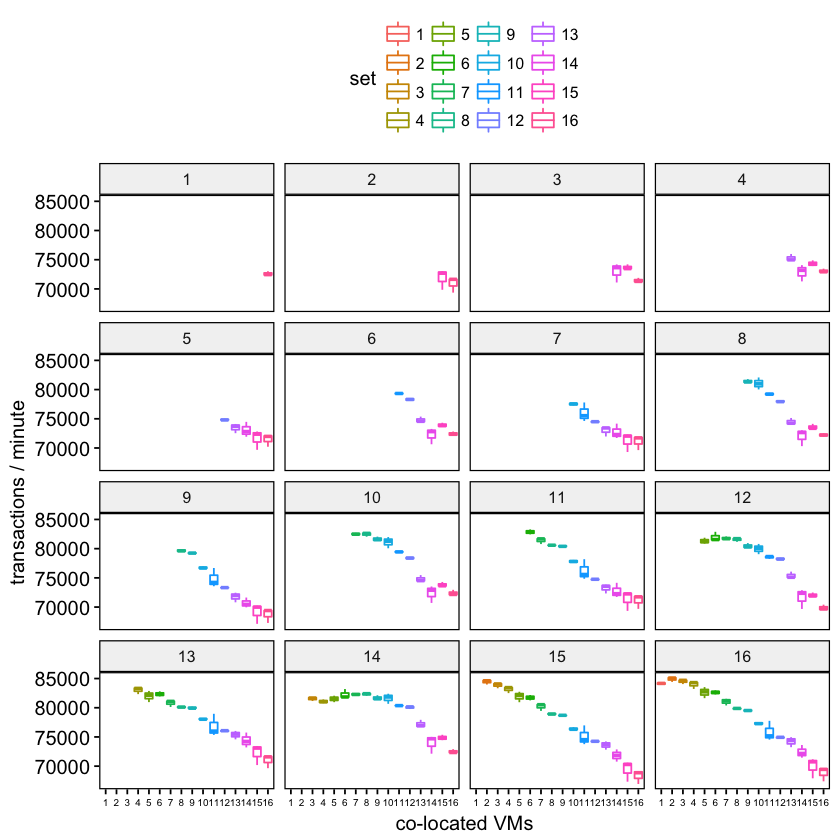

In [5]:
ggboxplot(samples, x = "set", y = "transactions", 
          color = "set", 
          ylab = "transactions / minute", xlab = "co-located VMs",facet.by='vmID',font.xtickslab = 6)


# Conclusion

Graph2 shows a result perfectly matched our expectation.<br>
Perormance of VM16 degraded from 85000 per transactions  minute to about 70000 after other VMs are involved.<br>
In addtion, local disks performed a 85000 is resonbale given that EBS-backed volume performed around 60000 while other configurations are the same.<br> 

Let's take a look at the VM16.
It is roughly linear except first 1 or 2 sets of test for each VM.<br>
Training effect or cache may be the reason that set1 isn't better than set2,<br>
where we respectively got 84137.67 and 84667.67 transactions on average of 3 cycle.<br>

In [22]:
library(randomForest)
wholeSet = read.csv("../modeldata/c3/merged.csv")
    modelRandomForest = readRDS("../modeldata/c3/modelRandomForest.rds")

In [25]:
predicted <- predict(modelRandomForest, wholeSet)
cat("R-squared:",cor(predicted, wholeSet[,'set'])^2,"\n")
roundedPred = floor(predicted + 0.5)
cat("R-squared:",cor(roundedPred, wholeSet[,'set'])^2,"\n")

R-squared: 0.990435 


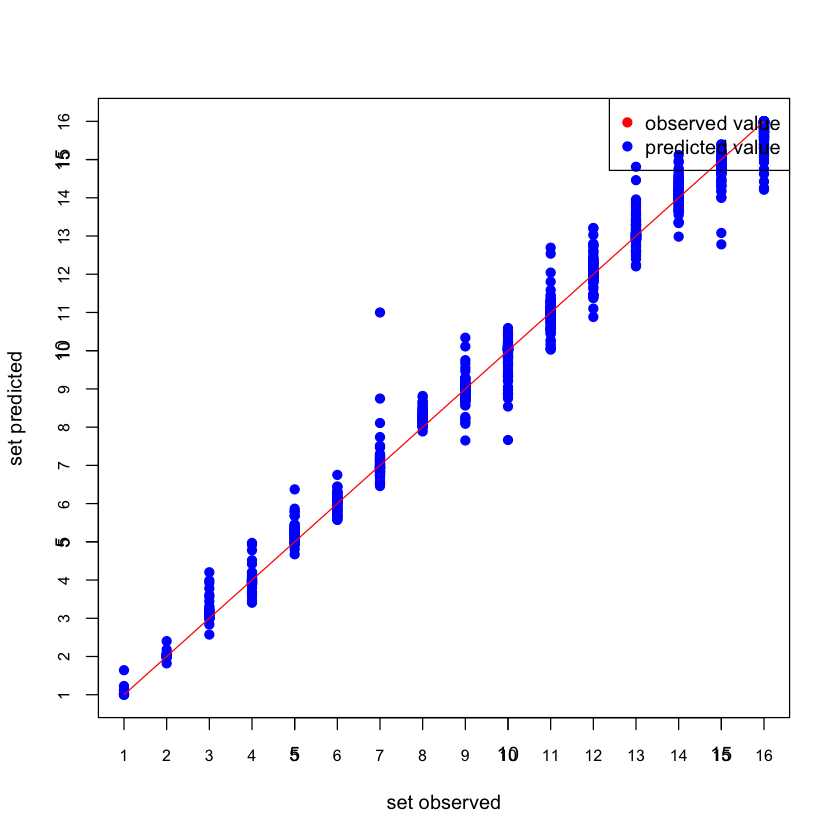

In [27]:
comparason = cbind(predicted,wholeSet['set'])
colnames(comparason) =c("pred","set")
plot(x = comparason$set , y = comparason$pred,col="blue",pch=19,xlab="set observed",ylab="set predicted")
axis(1,1:16,1:16,cex.axis=0.8)
axis(2,1:16,1:16,cex.axis=0.8)
par(new=TRUE)
lines(x = range(1:16) , y = range(1:16),col="red")
legend("topright",legend=c("observed value","predicted value"),pch=19, col=c("red","blue"))

In [28]:
library(randomForest)
library(rpart)
wholeSet = read.csv("../modeldata/c3/merged.csv")

trainingSize = nrow(wholeSet) * .9
trainingSetIndices = sample(1:nrow(wholeSet), trainingSize)
testingSetIndices = setdiff(rownames(wholeSet),trainingSetIndices)
trainingSet = wholeSet[trainingSetIndices,]
testingSet = wholeSet[testingSetIndices,]
formula = set~iperf+sysbench+ycruncher+pgbench

In [29]:
modelRandomForest <- randomForest(
    formula,
    data=trainingSet,
    mtry=4,
    ntree=1001
)
modelRandomForest


Call:
 randomForest(formula = formula, data = trainingSet, mtry = 4,      ntree = 1001) 
               Type of random forest: regression
                     Number of trees: 1001
No. of variables tried at each split: 4

          Mean of squared residuals: 0.5695562
                    % Var explained: 96.14

In [30]:
predicted <- predict(modelRandomForest, testingSet)
cat("R-squared:",cor(predicted, testingSet[,'set'])^2,"\n")



R-squared: 0.9703951 


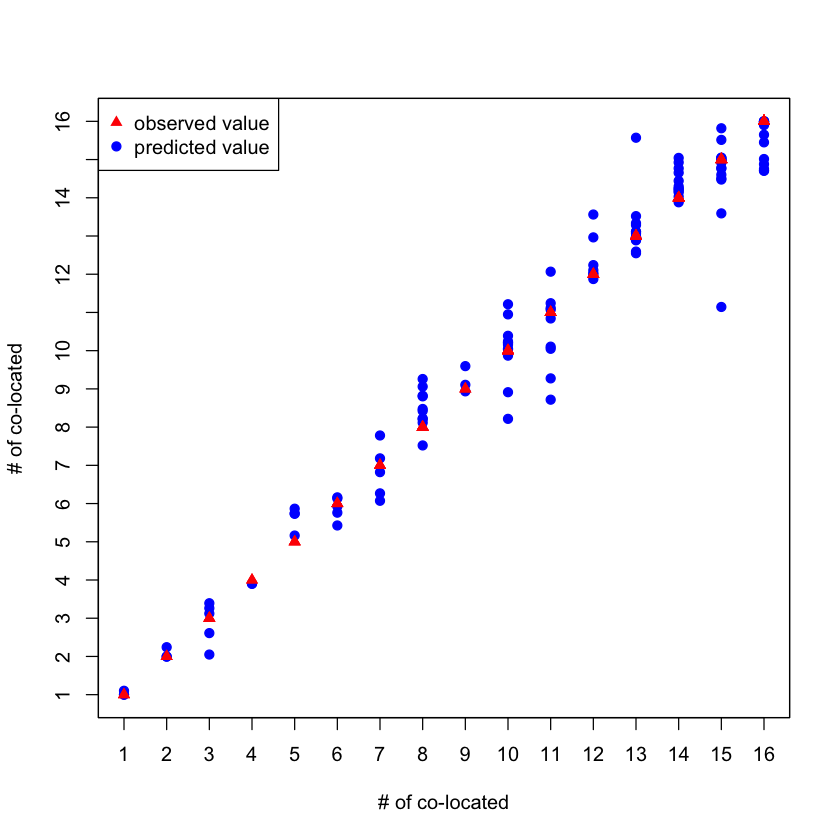

In [106]:
comparason = cbind(predicted,testingSet['set'])

plot(x = comparason$set , y = comparason$predicted,col="blue",pch=19,xlab="# of co-located",ylab="# of co-located", xaxt='n',yaxt='n')
par(new=TRUE)
plot(x = comparason$set , y = comparason$set, col="red",pch=17, xlab='', ylab='', xaxt='n',yaxt='n')
axis(1,1:16)
axis(2,1:16)
legend("topleft",legend=c("observed value","predicted value"),pch=c(17,19), col=c("red","blue"))
